In [11]:
import numpy as np
import matplotlib.pyplot as plt

#### Text used for corpus

In [12]:
text = """A university (Latin: universitas, 'a whole') is an institution of higher (or tertiary) education and research which awards academic degrees in various academic disciplines. Universities typically offer both undergraduate and postgraduate programs. In the United States, universities must offer graduate degrees; institutions offering only undergraduate degrees are colleges.

The word university is derived from the Latin universitas magistrorum et scholarium, which roughly means "community of teachers and scholars".
"""

#### Preprocessing

In [13]:
stopwords = {'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'same',
 'shan',
 "shan't",
 'she',
 "she's",
 'should',
 "should've",
 'shouldn',
 "shouldn't",
 'so',
 'some',
 'such',
 't',
 'than',
 'that',
 "that'll",
 'the',
 'their',
 'theirs',
 'them',
 'themselves',
 'then',
 'there',
 'these',
 'they',
 'this',
 'those',
 'through',
 'to',
 'too',
 'under',
 'until',
 'up',
 've',
 'very',
 'was',
 'wasn',
 "wasn't",
 'we',
 'were',
 'weren',
 "weren't",
 'what',
 'when',
 'where',
 'which',
 'while',
 'who',
 'whom',
 'why',
 'will',
 'with',
 'won',
 "won't",
 'wouldn',
 "wouldn't",
 'y',
 'you',
 "you'd",
 "you'll",
 "you're",
 "you've",
 'your',
 'yours',
 'yourself',
 'yourselves'}

In [14]:
def preprocess(text):
    global stopwords
    punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    sentences = text.split('.')
    corpus = []

    for i, sentence in enumerate(sentences):
        sentences[i] = sentence.strip()
        corpus.append([])
        for word in sentence.split():
            word = word.strip(punctuation)
            if word not in stopwords:
                corpus[i].append(word.lower())


    return corpus

#### Word2Vec class

In [15]:
class word2vec():
    def __init__(self, corpus, window_size = 2, embedding_size = 100):
        self.corpus = corpus
        self.window_size = window_size
        self.embedding_size = embedding_size
        vocab = []
        self.vocab_size = 0
        for doc in corpus:
            for word in doc:
                if word not in vocab:
                    vocab.append(word)
                    self.vocab_size+=1
        vocab = sorted(vocab)
        self.word2idx = dict(zip(vocab, range(self.vocab_size)))
        self.idx2word = dict(zip(range(self.vocab_size), vocab))
        self.X_train = []
        self.Y_train = []
        for doc in corpus:
            for i in range(len(doc)):
                centerWord = np.zeros(self.vocab_size)
                centerWord[self.word2idx[doc[i]]] = 1
                contextWords = np.zeros(self.vocab_size)
                for j in range(i - self.window_size, i + self.window_size):
                    if i != j and j >= 0 and j < len(doc):
                        contextWords[self.word2idx[doc[j]]] = 1
                self.X_train.append(centerWord)
                self.Y_train.append(contextWords)
        self.m = len(self.X_train)
        self.CurrSampleIdx = 0

    def sigmoid(self, x):
        z = 1 / (1 + np.exp(-x))
        return z
  
    def softmax(self, Z):
        t = np.exp(Z)
        return t / (np.sum(t, keepdims = True, axis=0))

    def initialize_weights(self):
        V = self.vocab_size
        d = self.embedding_size

        np.random.seed(25)

        self.centerWordVectors = np.random.uniform(-0.8, 0.8, (V, d))
        self.contextWordVectors = np.random.uniform(-0.8, 0.8, (d, V))
    
        
    def skipgram_naiveSoftmax(self, SampleIdx, K=None):
        X_trainSample = np.array( self.X_train[SampleIdx] ).reshape(self.vocab_size, 1)
        Y_trainSample = np.array( self.Y_train[SampleIdx] ).reshape(1, self.vocab_size)

        CurrCenterWordIdx = np.argmax( np.array( self.X_train[SampleIdx] ).flatten())

        #Feed Forward
        CurrCenterWordVec = self.centerWordVectors[CurrCenterWordIdx].reshape(self.embedding_size, 1)
        u = np.dot(self.contextWordVectors.T, CurrCenterWordVec)
        Y_pred = self.softmax(u)

        e = Y_pred - Y_trainSample.T    # shape is (V,1)

        #Back Propagation
        gradContextWordVectors = np.dot(CurrCenterWordVec, e.T) # shape (d, V)
        a = np.dot(self.contextWordVectors, e)
        gradCenterWordVectors = np.dot(X_trainSample, a.T)      # shape (V, d)

        return gradContextWordVectors, gradCenterWordVectors, u
                

    def sgd_train(self, learning_rate, nEpoch, PRINT_EVERY = 1, PLOT_COSTS = False, model = None, K = None):
        if model == 'skipgram_naiveSoftmax' or model == None:
            model = self.skipgram_naiveSoftmax
        elif model == 'skipgram_negSampling':
            model = self.skipgram_negSampling
        else:
            print('model does not exist')
            return -1
        costs = []
        for epoch in range(1, nEpoch + 1):
            cost = 0.0
            for SampleIdx in range(len(self.X_train)):
                gradContextWordVectors, gradCenterWordVectors, outputLayer = model(SampleIdx) # pass the training sample into NN, which returns the gradients
                
                #Updating weights
                self.centerWordVectors -= learning_rate * gradCenterWordVectors
                self.contextWordVectors -= learning_rate * gradContextWordVectors
                    
                #Updating loss
                c = 0
                for i in range(self.vocab_size):
                    if(self.Y_train[SampleIdx][i]):
                        cost += -1*outputLayer[i][0]
                        c += 1
                cost += c*np.log(np.sum(np.exp(outputLayer)))

            if  epoch % PRINT_EVERY == 0:
                print('epoch:',epoch,'cost:',cost, 'lr:', learning_rate)
            #if epoch % 200 == 0:
            #    learning_rate *= 0.5
            costs.append(cost)
        
        #Plot Costs
        costs = np.squeeze(costs)
        if PLOT_COSTS == True:
            fig = plt.figure()
            fig.patch.set_facecolor('w')
            plt.plot(costs)
            plt.ylabel('cost')
            plt.xlabel('epoch')
            plt.title("Word2Vec: Learning Curves")
            plt.show()

    def predict(self,word,number_of_predictions):
        word = word.lower()
        if word in self.word2idx.keys():
            idx = self.word2idx[word]
            d1, d2, u = self.skipgram_naiveSoftmax(idx)
            prediction = self.softmax(u)
            output = {}
            for i in range(self.vocab_size):
                output[prediction[i][0]] = i
            
            predicted_words = []
            for k in sorted(output,reverse=True):
                predicted_words.append(self.idx2word[output[k]])
                if(len(predicted_words)>=number_of_predictions):
                    break
    
            return predicted_words
        else:
            print("Word not found")

#### Training

epoch: 10 cost: 740.4359172920182 lr: 0.001
epoch: 20 cost: 645.3759932742136 lr: 0.001
epoch: 30 cost: 564.1307867631093 lr: 0.001
epoch: 40 cost: 495.4600155650397 lr: 0.001
epoch: 50 cost: 437.51524014655445 lr: 0.001
epoch: 60 cost: 388.7925362206167 lr: 0.001
epoch: 70 cost: 348.0349237562134 lr: 0.001
epoch: 80 cost: 314.2227896216596 lr: 0.001
epoch: 90 cost: 286.5686917903925 lr: 0.001
epoch: 100 cost: 264.1562282657596 lr: 0.001
epoch: 110 cost: 245.99543002950824 lr: 0.001
epoch: 120 cost: 231.26041046699362 lr: 0.001
epoch: 130 cost: 219.32037085043524 lr: 0.001
epoch: 140 cost: 209.68561113255856 lr: 0.001
epoch: 150 cost: 201.9630153951922 lr: 0.001
epoch: 160 cost: 195.83073630046565 lr: 0.001
epoch: 170 cost: 191.02045305875018 lr: 0.001
epoch: 180 cost: 187.3009181604196 lr: 0.001
epoch: 190 cost: 184.46781097680244 lr: 0.001
epoch: 200 cost: 182.3436102123915 lr: 0.001


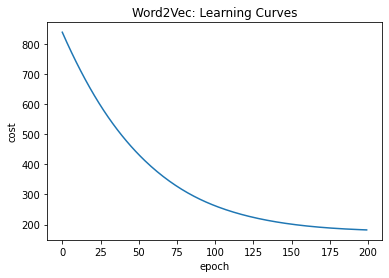

In [16]:
corpus = preprocess(text)
w2v = word2vec(corpus, window_size = 2, embedding_size = 150)
w2v.initialize_weights()
w2v.sgd_train(learning_rate = 0.001, nEpoch = 200, PRINT_EVERY = 10, PLOT_COSTS = True, model = 'skipgram_naiveSoftmax')

In [17]:
w2v.predict("university",5)

['the', 'university', 'graduate', 'teachers', 'institutions']